# Assignment 1: Spark Funds

## Objective

#### Spark Funds has two minor constraints for investments:

    1. It wants to invest between 5 to 15 million USD per round of investment
    2. It wants to invest only in English-speaking countries because of the ease of communication with the companies it would invest in

#### Analysis
    1. Identify the best Investment type from venture, seed, angel, private equity etc
    
    2. Identifying best countries for investing (English Speaking)
    
    3. understanding the distribution among 8 main sectors

## Checkpoints 1 : Data Cleaning

In [2]:
import pandas as pd

# reading companies text file as dataframe
companies = pd.read_csv(r'companies.txt',sep="\t", engine='python')
# changing uniqueID coloumn 'permalink' to upper case for further processing
companies['permalink'] = list(map(lambda s: s.upper(),companies['permalink']))

# reading rounds csv file as dataframe
rounds2 = pd.read_csv(r'rounds2.csv', sep=',', engine='python')
# changing uniqueID coloumn 'company_permalink' to upper case for further processing
rounds2['company_permalink'] = list(map(lambda s: s.upper(),rounds2['company_permalink']))


In [3]:
# unique company values in companies dataframe
unique_companies = list(set(companies['permalink']))
print('Unique Companies in companies dataframe :', len(unique_companies))

# unique company values in rounds2 dataframe 
unique_companies_rounds = list(set(rounds2['company_permalink']))
print('Unique Companies in rounds dataframe :', len(unique_companies_rounds))


# condition check for companies in rounds2 dataframe and not in companies dataframe
if len(set(unique_companies_rounds).difference(set(unique_companies))) > 0:
    print('Y')
else:
    print('N')

Unique Companies in companies dataframe : 66368
Unique Companies in rounds dataframe : 66368
N


In [4]:
# Merging dataframe 'rounds2' and 'companies'
master_frame = rounds2.merge(companies, how='left',left_on='company_permalink', right_on='permalink',)
master_frame['raised_amount_usd'].fillna(0, inplace=True)
print('total records in master_frame', len(master_frame))


total records in master_frame 114949


## Checkpoint 2: Funding Analysis

In [5]:
# groupby frame on funding type and taking a mean of raised amout will give us the most representative value 
mean_funding_type= (master_frame.groupby(['funding_round_type']))['raised_amount_usd'].mean().to_frame()
print(mean_funding_type.loc[['angel','venture', 'seed','private_equity']])


                    raised_amount_usd
funding_round_type                   
angel                    7.645643e+05
venture                  1.063405e+07
seed                     5.566067e+05
private_equity           6.211179e+07


## Checkpoint 3: country analysis

In [6]:
# subsetting out master dataframe for ventur funding type only
subset_master_frame = master_frame[master_frame['funding_round_type']=='venture'].reset_index(drop=True)
order_countries = subset_master_frame.groupby(['country_code'])['raised_amount_usd'].sum().sort_values(ascending = False)
# result for countries investimg in venture in decending order
print(order_countries.head(9))    

top9 = subset_master_frame[subset_master_frame['country_code'].isin(['USA','CHN','GBR','IND','CAN','FRA','ISR','DEU','JPN'])].reset_index(drop=True)

#print(top9)

country_code
USA    4.225108e+11
CHN    3.983542e+10
GBR    2.024563e+10
IND    1.439186e+10
CAN    9.583332e+09
FRA    7.259537e+09
ISR    6.907515e+09
DEU    6.346960e+09
JPN    3.363677e+09
Name: raised_amount_usd, dtype: float64


Based on the link https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language shared at the upgrad Assignment section for identifying the top 3 countries where English is an official language.

We have taken the following english speaking countries from top9 dataframe for our work further :
USA (united states of America)
GBR (United Kingdom)
CAN (Canada)


## Checkpoint 4 : Sector Analysis 1

In [7]:
# Reading the mapping file for analysis
mapping  = pd.read_csv(r'mapping.csv', sep=',', engine='python')
mapping.drop(['Blanks'], axis=1, inplace=True)
# the following function converts the one hot encoding in mapping file to a derived frame from further analytics simpliity in this case.

def mapping_conversion(df):
    temp = {}
    for i in range(len(df)):
        tem = df.loc[i].to_frame().reset_index()
        #cate_temp =[]
        for j in range(len(tem)):
            if tem.loc[j, i] == 1:
                #cate_temp.append(tem.loc[j,'index'])
                temp.update({df.loc[i,'category_list']: tem.loc[j,'index']})

    z = pd.DataFrame(list(temp.items()), columns=['category_list', 'category'])
    return z

mapping = mapping_conversion(mapping)

In [8]:
# primary sector extraction from top9 dataframe 
top9['category_list'] = top9['category_list'].str.split("|").str[0]

# merging the dataframes on the 'category_list'
# Code for a merged data frame with each primary sector mapped to its main sector
result = pd.merge(top9, mapping, how='left', on='category_list')


In [9]:
#******* Total number of Investments (count) *************
Country_USA_1 = result[result['country_code']=='USA']
Country_GBR_2 = result[result['country_code']=='GBR']
Country_CAN_3 = result[result['country_code']=='CAN']


In [10]:
Country_CAN_3['funded_at'].isnull().sum()

############# Total amount of investment (USD)
print('Total investment recieved by USA: ', Country_USA_1['raised_amount_usd'].sum())
print('Total investment recieved by GBR: ',Country_GBR_2['raised_amount_usd'].sum())
print('Total investment recieved by CAN: ',Country_CAN_3['raised_amount_usd'].sum())


print('\nInvestment of USA in sectors ',Country_USA_1.groupby(['category'])['company_permalink'].count().sort_values(ascending = False))
print('\n\nInvestment of GBR in sectors ',Country_GBR_2.groupby(['category'])['company_permalink'].count().sort_values(ascending = False))
print('\n\nInvestment of CAN in sectors ',Country_CAN_3.groupby(['category'])['company_permalink'].count().sort_values(ascending = False))

############ Top Sector name (no. of investment-wise)
print('\n Total number of investment in top sector for USA ', len(Country_USA_1[Country_USA_1['category']=='Others']))
print('\n Total number of investment in top sector for GBR ', len(Country_GBR_2[Country_GBR_2['category']=='Others']))
print('\n Total number of investment in top sector for CAN ', len(Country_CAN_3[Country_CAN_3['category']=='Cleantech / Semiconductors']))

########### Second Sector name (no. of investment-wise)
len(Country_USA_1[Country_USA_1['category']=='Cleantech / Semiconductors'])
len(Country_GBR_2[Country_GBR_2['category']=='Cleantech / Semiconductors'])
len(Country_CAN_3[Country_CAN_3['category']=='Others'])

############### Third Sector name (no. of investment-wise)
len(Country_USA_1[Country_USA_1['category']=='Social, Finance, Analytics, Advertising'])
len(Country_GBR_2[Country_GBR_2['category']=='Social, Finance, Analytics, Advertising'])
len(Country_CAN_3[Country_CAN_3['category']=='Social, Finance, Analytics, Advertising'])

###################For point 3 (top sector count-wise), which company received the highest investment?
Country_USA_1[Country_USA_1['category']=='Others'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)
Country_GBR_2[Country_GBR_2['category']=='Others'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)
Country_CAN_3[Country_CAN_3['category']=='Cleantech / Semiconductors'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)

#####################For point 4 (second best sector count-wise), which company received the highest investment?
Country_USA_1[Country_USA_1['category']=='Cleantech / Semiconductors'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)
Country_GBR_2[Country_GBR_2['category']=='Cleantech / Semiconductors'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)
Country_CAN_3[Country_CAN_3['category']=='Others'].groupby(['company_permalink'])['raised_amount_usd'].sum().sort_values(ascending = False)



Total investment recieved by USA:  422510842796.0
Total investment recieved by GBR:  20245627416.0
Total investment recieved by CAN:  9583332317.0

Investment of USA in sectors  category
Others                                     8693
Cleantech / Semiconductors                 8113
Social, Finance, Analytics, Advertising    5553
News, Search and Messaging                 4562
Health                                     3403
Manufacturing                              2643
Entertainment                              1888
Automotive & Sports                         566
Name: company_permalink, dtype: int64


Investment of GBR in sectors  category
Others                                     571
Cleantech / Semiconductors                 456
Social, Finance, Analytics, Advertising    359
News, Search and Messaging                 265
Entertainment                              157
Manufacturing                              132
Health                                     126
Automotive & Sports  

company_permalink
/ORGANIZATION/DESIRE2LEARN                           165000000.0
/ORGANIZATION/BUILDDIRECT                            112214350.0
/ORGANIZATION/TROPIC-NETWORKS                         86000000.0
/ORGANIZATION/TERADICI                                82821087.0
/ORGANIZATION/KOBO                                    78812455.0
                                                        ...     
/ORGANIZATION/PHOENIX-LABS                                   0.0
/ORGANIZATION/ASIA-PACIFIC-MARINE-CONTAINER-LINES            0.0
/ORGANIZATION/TENZING-MANAGED-IT-SERVICES                    0.0
/ORGANIZATION/TALENTCLICK                                    0.0
/ORGANIZATION/EXACTFLAT                                      0.0
Name: raised_amount_usd, Length: 210, dtype: float64

## Checkpoints 6: Plots

  funding_round_type  raised_amount_usd
0              angel       4.659255e+09
1     private_equity       1.419254e+11
2               seed       1.698986e+10
3            venture       5.901262e+11


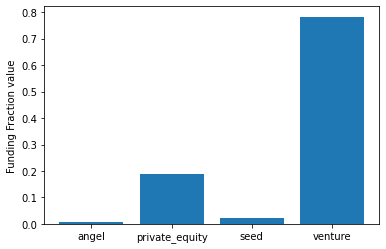

In [11]:
# importing the matplotlib library for plotting of data
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

#Extracting the total funding for the 4 categories ['venture','seed','private_equity','angel'] from master_frame dataframe

p1 = master_frame[master_frame['funding_round_type'].isin(['venture','seed','private_equity','angel'])]
p1 = (p1.groupby(['funding_round_type']))['raised_amount_usd'].sum().to_frame().reset_index()
print(p1)

# plotting a bargraph for visualisation of funding amount vs funding type

ax =fig.add_subplot(111)
funding_type = p1['funding_round_type']
fraction_fund = list(map(lambda x: x/p1['raised_amount_usd'].sum(),list(p1['raised_amount_usd'])))
ax.bar(funding_type,fraction_fund)
ax.set_ylabel('Funding Fraction value')
plt.show()

The above plot shows how venture funding was most common type of funding globally 

['CAN', 'CHN', 'DEU', 'FRA', 'GBR', 'IND', 'ISR', 'JPN', 'USA']


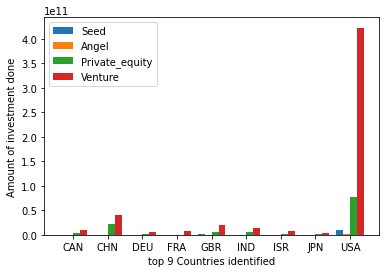

In [12]:
# subsetting the master_frame for top9 countries identified earlier and for the 4 identified investment type 
p2 = master_frame[master_frame['country_code'].isin(['USA','CHN','GBR','IND','CAN','FRA','ISR','DEU','JPN'])].reset_index(drop=True)
p2 = p2[p2['funding_round_type'].isin(['venture','seed','private_equity','angel'])]
p2 = (p2.groupby(['country_code','funding_round_type']))['raised_amount_usd'].sum().to_frame().reset_index()

# closing the figure 
fig = plt.figure()
bx = fig.add_subplot(111)

# funstion to create a list of unique country code in their correct sequence for correct representation of values
def unique_country_seq(df):
    temp =[]
    for i in range(len(df)):
        a= df.loc[i, 'country_code']
        if a not in temp:
            temp.append(df.loc[i, 'country_code'])
    return temp
country = unique_country_seq(p2)
print(country)
# encoding the country values
ypos = np.arange(len(country))

# subsetting the dataframe further for each funding type
temp1 = p2[p2['funding_round_type']=='venture']
temp2 = p2[p2['funding_round_type']=='seed']
temp3 = p2[p2['funding_round_type']=='angel']
temp4 = p2[p2['funding_round_type']=='private_equity']
bx.bar(ypos-0.3, temp2['raised_amount_usd'], width =0.2,label='Seed')
bx.bar(ypos-0.1, temp3['raised_amount_usd'], width =0.2,label='Angel')
bx.bar(ypos+0.1, temp4['raised_amount_usd'], width =0.2,label='Private_equity')
bx.bar(ypos+0.3, temp1['raised_amount_usd'], width =0.2,label='Venture')

#show legend
plt.legend()
# decoding the xlables for our plot
plt.xticks(ypos, country)

#adding labels to axes
plt.ylabel('Amount of investment done')
plt.xlabel('top 9 Countries identified')
plt.show()

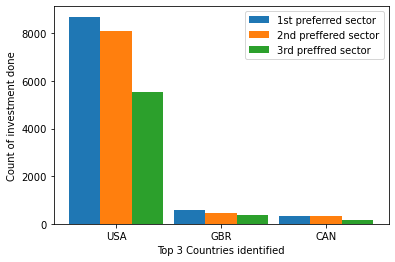

In [13]:

country = ['USA', 'GBR', 'CAN']
# the data taken in the list as count of investment done is printed in the above sections for reference
top1_sec=[8693, 571, 346]
top2_sec =[8113, 456, 337]
top3_sec=[5553,359,175]

fig = plt.figure()
cx = fig.add_subplot(111)

# encoding the country values
ypos = np.arange(len(country))
cx.bar(ypos-0.3, top1_sec, width =0.3,label='1st preferred sector')
cx.bar(ypos, top2_sec, width =0.3,label='2nd preffered sector')
cx.bar(ypos+0.3, top3_sec, width =0.3,label='3rd preffred sector')

#show legend
plt.legend()
# decoding the xlables for our plot
plt.xticks(ypos, country)
#adding labels to axes
plt.ylabel('Count of investment done')
plt.xlabel('Top 3 Countries identified')
plt.show()

The final conclusion that can be thus made for Spark Funds to invest are : 

1. The Funding type should be ‘VENTURE’
2. The investment should be done in ‘USA’ for a risk free approach in the market